# 3.2 Fun with Rekognition DetectFaces and SearchFacesByImage
----
This is fun but optional module. Here we are going to take a look at extracting and indexing multiple faces, from an image. Once we have the collection of images we'll compare all faces in an image with Amazon Rekognition against your collection.

## Steps 

1. Load packages 
2. View existing collections 
3. Create a new collection 
4. Download some images and unzip them into a directory 
5. Index the faces found into the collection 
6. Find and present faces found in an image vs. the faces stored in your collection 
7. Clean up!! 


The following notebook will guide you through on how to compare all faces detected in an image against your Amazon Rekognition Face Collection. 

## Step 1. Load Libraries 

In [1]:
import boto3, json, os, io
from PIL import Image, ImageDraw, ExifTags, ImageColor
from IPython.display import Image as IImage
client=boto3.client('rekognition')

## Step 2. View your existing collections

In [2]:
def list_collections():

    max_results=10
    
    #Display all the collections
    print('Displaying collections...')
    response=client.list_collections(MaxResults=max_results)
    collection_count=0
    done=False
    
    while not done:
        collections=response['CollectionIds']

        for collection in collections:
            print (collection)
            collection_count+=1
        if 'NextToken' in response:
            nextToken=response['NextToken']
            response=client.list_collections(NextToken=nextToken,MaxResults=max_results)
            
        else:
            done=True

    return collection_count   

collection_count=list_collections()
print("collections: " + str(collection_count))


Displaying collections...
AWS_On_Air
collection_id
collections: 2


## Step 3. Create a new collection
-----

Remember you must use a unique name if you are creating a new collection

In [3]:
collection_id='Avengers_Collection' # Remember you must use a unique name if you are creating a new collection

In [4]:
def create_collection(collection_id):
    #Create a collection
    print('Creating collection:' + collection_id)
    try:
        response=client.create_collection(CollectionId=collection_id)
    except:
        client.delete_collection(CollectionId=collection_id)
        response=client.create_collection(CollectionId=collection_id)
    print('Collection ARN: ' + response['CollectionArn'])
    print('Status code: ' + str(response['StatusCode']))
    print('Done...')
    
create_collection(collection_id)

Creating collection:Avengers_Collection
Collection ARN: aws:rekognition:us-west-2:304243717290:collection/Avengers_Collection
Status code: 200
Done...


### Step 3a. Confirm your collection creation. 
-----


In [5]:
collection_count=list_collections()
print("collections: " + str(collection_count))

Displaying collections...
AWS_On_Air
Avengers_Collection
collection_id
collections: 3


## Step 4. Download collection images
---
here we are going to download a zip file of images, unzip it and then index it. 

In [6]:
!rm -R avengers_face_search
!curl https://dz4iesrkqs7j9.cloudfront.net/random/avengers_face_search.zip -O
!unzip avengers_face_search.zip
!rm -R __MACOSX
!rm avengers_face_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2279k  100 2279k    0     0  6303k      0 --:--:-- --:--:-- --:--:-- 6333k
Archive:  avengers_face_search.zip
   creating: avengers_face_search/
   creating: avengers_face_search/test/
   creating: avengers_face_search/populate/
  inflating: avengers_face_search/test/Avengers_test_1.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_1.jpg  
  inflating: avengers_face_search/test/Avengers_test_2.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_2.jpg  
  inflating: avengers_face_search/test/Avengers_test_3.jpg  
  inflating: __MACOSX/avengers_face_search/test/._Avengers_test_3.jpg  
  inflating: avengers_face_search/populate/Nebula.jpg  
  inflating: __MACOSX/avengers_face_search/populate/._Nebula.jpg  
  inflating: avengers_face_search/populate/Ant_Man.jpg  
  inflating: __MACOSX/avengers

## Step 5. Index faces (add faces to a collection) 
-----
Here we are going to iterate over the files in the population folder and index their faces. 

In [7]:
directory = 'avengers_face_search/populate'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    with open(f, "rb") as file:
        print(f)
        file = open(f, "rb") # opening for [r]eading as [b]inary
        data = file.read() 
        response=client.index_faces(CollectionId=collection_id,
                            Image={'Bytes':data},
                            ExternalImageId=f.split("/")[2],
                            MaxFaces=1,
                            QualityFilter="AUTO",
                            DetectionAttributes=['ALL'])
        print ('Results for ' + f.split("/")[2])
        print('Faces indexed:')
        for faceRecord in response['FaceRecords']:
            print('  Face ID : ' + faceRecord['Face']['FaceId'])
            print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

        print('Faces not indexed:')
        for unindexedFace in response['UnindexedFaces']:
            print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
            print(' Reasons :')
            for reason in unindexedFace['Reasons']:
                print('   ' + reason)
        file.close()


avengers_face_search/populate/Nebula.jpg
Results for Nebula.jpg
Faces indexed:
  Face ID : 6b06f343-8f1c-4e8e-844b-67b68cc11c3f
  Location: {'Width': 0.183916836977005, 'Height': 0.5114789009094238, 'Left': 0.41917920112609863, 'Top': 0.280009388923645}
Faces not indexed:
avengers_face_search/populate/Ant_Man.jpg
Results for Ant_Man.jpg
Faces indexed:
  Face ID : 78e5b00a-9c08-4554-83a3-149371e72a42
  Location: {'Width': 0.33715489506721497, 'Height': 0.22038093209266663, 'Left': 0.34082308411598206, 'Top': 0.04379643499851227}
Faces not indexed:
avengers_face_search/populate/Dora_Milaje.jpg
Results for Dora_Milaje.jpg
Faces indexed:
  Face ID : 54eb24c5-e244-4d2d-883a-3d08925235a4
  Location: {'Width': 0.355305552482605, 'Height': 0.3991573750972748, 'Left': 0.36674195528030396, 'Top': 0.13615210354328156}
Faces not indexed:
 Location: {'Width': 0.11015217751264572, 'Height': 0.16952276229858398, 'Left': 0.8856674432754517, 'Top': 0.37820354104042053}
 Reasons :
   EXCEEDS_MAX_FACES
 

### 5a. List faces in the collection

In [8]:
def list_faces_in_collection(collection_id):

    maxResults=20
    faces_count=0
    tokens=True

    response=client.list_faces(CollectionId=collection_id,
                               MaxResults=maxResults)

    print('Faces in collection ' + collection_id)
 
    while tokens:

        faces=response['Faces']
        for face in faces:
            print (face["FaceId"],face["ExternalImageId"].split('.')[0])
            faces_count+=1
        if 'NextToken' in response:
            nextToken=response['NextToken']
            response=client.list_faces(CollectionId=collection_id,
                                       NextToken=nextToken,MaxResults=maxResults)
        else:
            tokens=False
    return faces_count   

faces_count=list_faces_in_collection(collection_id)
print("Faces in collection: " + str(faces_count))

Faces in collection Avengers_Collection
16163ccd-ab2d-476a-b6e6-08d3771dfd8d Captain_America
48664900-5a8d-4d15-acf1-fb6914dee6d0 Black_Widow
4b7e81c2-e978-46e6-b23f-fb2d5e820e37 Hulk
54eb24c5-e244-4d2d-883a-3d08925235a4 Dora_Milaje
6b06f343-8f1c-4e8e-844b-67b68cc11c3f Nebula
78e5b00a-9c08-4554-83a3-149371e72a42 Ant_Man
b1c321d6-6fe9-4fc8-a7f3-0c2bf4eb94be War_Machine
dae695c0-5af2-4659-b1c8-b6fa102d92c1 Iron_Man
e4fc2b5d-eb7e-4b63-8d18-7fd76188d1e8 Thor
f497da39-b092-41cf-82c3-bea4d2c68e7c Captain_Marvel
Faces in collection: 10


## Step 6. Find faces in photo

----
here we create a few functions that will be useful for transforming and detecting faces 

In [9]:
def transform_bounding(img, box):
    imgWidth, imgHeight = img.size
    l = (imgWidth * box['Left'])-5
    t = (imgHeight * box['Top'])-5
    w = (imgWidth * box['Width'])+10
    h = (imgHeight * box['Height'])+10
    return l,t,w,h

In [10]:
def detect_faces(file):
    faces = []
    f = open(file, "rb") # opening for [r]eading as [b]inary
    data = f.read() 
    response = client.detect_faces(Image={'Bytes':data})
    for face in response["FaceDetails"]:
        faces.append(face['BoundingBox'])
    print("Faces detected: " + str(len(response['FaceDetails'])))   
    return faces

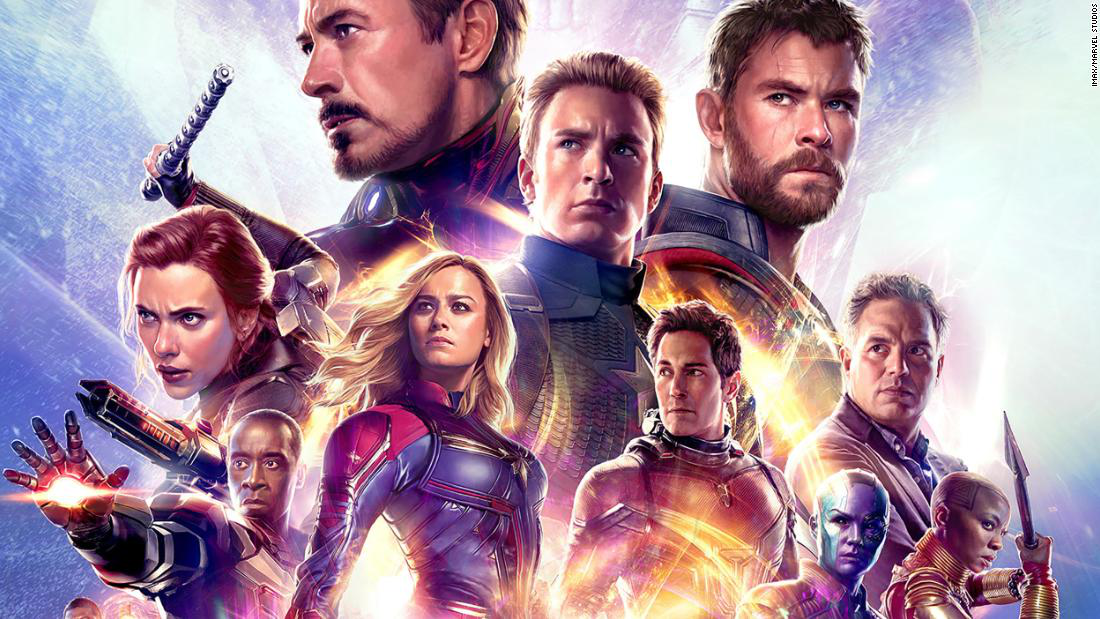

Faces detected: 10
face found


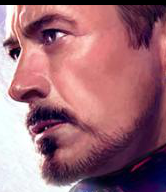

Character  : Iron_Man
Similarity : 66.13%
------------------------------
face found


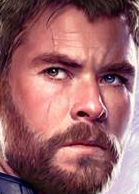

Character  : Thor
Similarity : 99.96%
------------------------------
face found


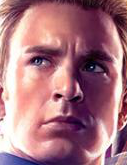

Character  : Captain_America
Similarity : 99.88%
------------------------------
face found


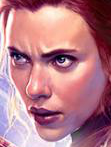

Character  : Black_Widow
Similarity : 96.18%
------------------------------
face found


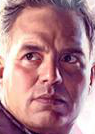

Character  : Hulk
Similarity : 98.93%
------------------------------
face found


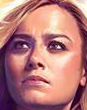

Character  : Captain_Marvel
Similarity : 99.95%
------------------------------
face found


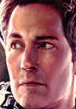

Character  : Ant_Man
Similarity : 98.87%
------------------------------
face found


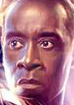

Character  : War_Machine
Similarity : 99.99%
------------------------------
face found


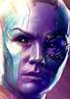

Character  : Nebula
Similarity : 97.51%
------------------------------
face found


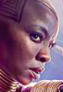

Character  : Dora_Milaje
Similarity : 99.99%
------------------------------


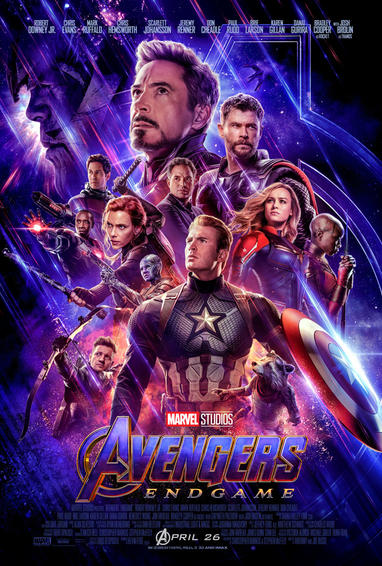

Faces detected: 10
face found


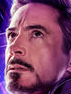

Character  : Iron_Man
Similarity : 99.84%
------------------------------
face found


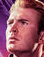

Character  : Captain_America
Similarity : 73.43%
------------------------------
face found


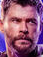

Character  : Thor
Similarity : 99.96%
------------------------------
face found


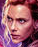

Character  : Black_Widow
Similarity : 91.02%
------------------------------
face found


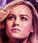

Character  : Captain_Marvel
Similarity : 99.56%
------------------------------
face found


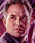

Character  : Hulk
Similarity : 64.57%
------------------------------
face found


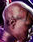

but no match found
------------------------------
face found


Character  : Ant_Man
Similarity : 93.00%
------------------------------
face found


but no match found
------------------------------
face found


Character  : War_Machine
Similarity : 96.11%
------------------------------


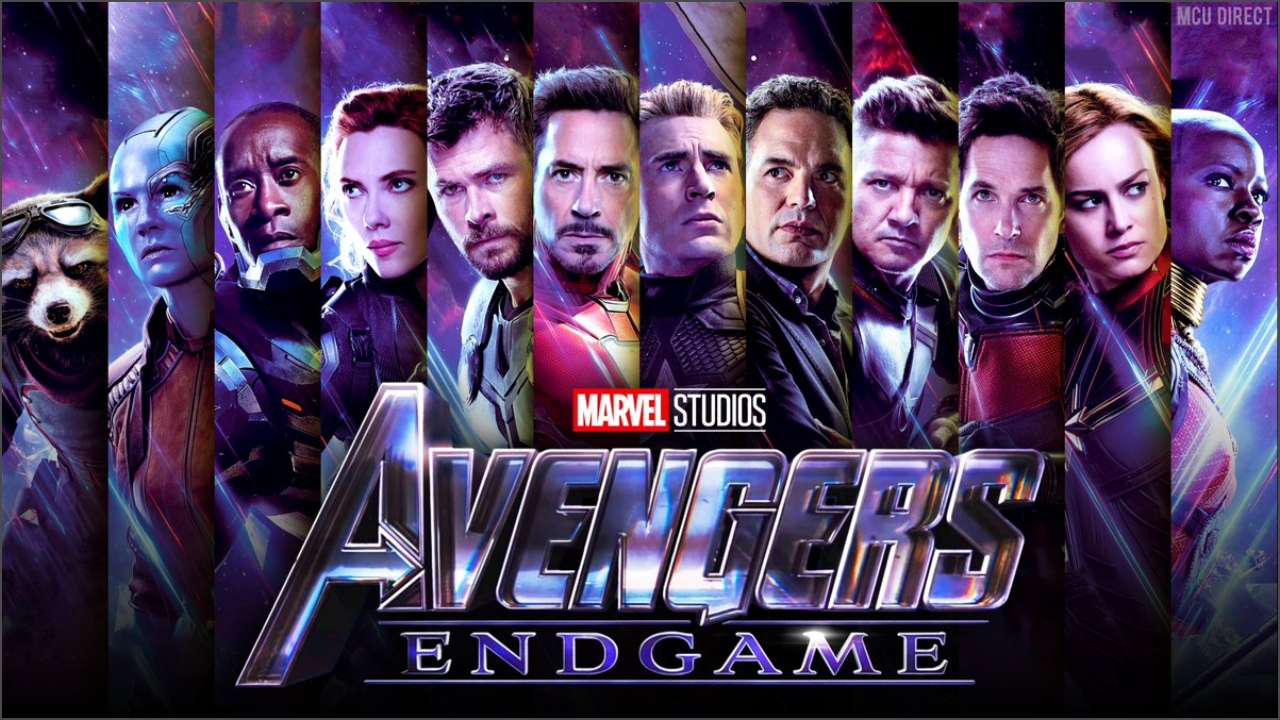

Faces detected: 11
face found


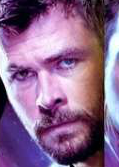

Character  : Thor
Similarity : 100.00%
------------------------------
face found


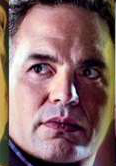

Character  : Hulk
Similarity : 99.47%
------------------------------
face found


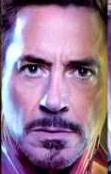

Character  : Iron_Man
Similarity : 97.53%
------------------------------
face found


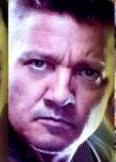

but no match found
------------------------------
face found


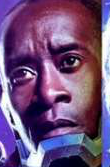

Character  : War_Machine
Similarity : 99.99%
------------------------------
face found


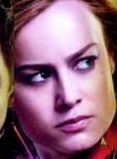

Character  : Captain_Marvel
Similarity : 99.97%
------------------------------
face found


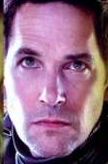

Character  : Ant_Man
Similarity : 99.97%
------------------------------
face found


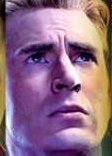

Character  : Captain_America
Similarity : 94.84%
------------------------------
face found


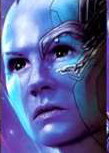

Character  : Nebula
Similarity : 73.38%
------------------------------
face found


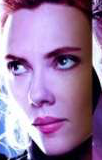

Character  : Black_Widow
Similarity : 94.23%
------------------------------
face found


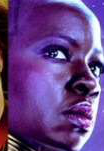

Character  : Dora_Milaje
Similarity : 99.93%
------------------------------


In [11]:
directory = 'avengers_face_search/test'

from PIL import Image               # to load images
from IPython.display import display # to display images

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    with open(f, "rb") as file:
        img = Image.open(f)
        display(img)
        faces = detect_faces(f)        
        for face in faces:
            l,t,w,h = transform_bounding(img,face)
            cropped = img.crop((l,t,l+w,t+h))    

            stream = io.BytesIO()
            cropped.save(stream, format='JPEG')
            bin_img = stream.getvalue()

            response0 = client.detect_faces(
                Image={'Bytes': bin_img},
            )

            if len(response0['FaceDetails']) > 0:
                print("face found")
                display(cropped)
                response1=client.search_faces_by_image(CollectionId="Avengers_Collection",
                                                  Image={'Bytes': bin_img},
                                                  FaceMatchThreshold=50)
                faceMatches=response1['FaceMatches']
                if(len(faceMatches) > 0):
                    for match in faceMatches:
                        print ('Character  : ' + match['Face']['ExternalImageId'].split('.')[0])
                        print ('Similarity : ' + "{:.2f}".format(match['Similarity']) + "%")
                else:
                    print("but no match found")
            else:
                print("face not found in the following crop")
                cropped.show()

            print("------------------------------")  

## Clean up the resources

Delete your face collection 

In [12]:
def delete_collection(collection_id):


    print('Attempting to delete collection ' + collection_id)
    client=boto3.client('rekognition')
    status_code=0
    try:
        response=client.delete_collection(CollectionId=collection_id)
        status_code=response['StatusCode']
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'ResourceNotFoundException':
            print ('The collection ' + collection_id + ' was not found ')
        else:
            print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
        status_code=e.response['ResponseMetadata']['HTTPStatusCode']
    return(status_code)


def main():
    collection_id='Avengers_Collection'
    status_code=delete_collection(collection_id)
    print('Status code: ' + str(status_code))

if __name__ == "__main__":
    main()  

Attempting to delete collection Avengers_Collection
Status code: 200
